# Define vector 3D class

In [1]:
import math
import numpy as np

class Vector3D:
    def __init__(self, initial_x = 0.0, initial_y = 0.0, initial_z = 0.0):
        self.x = initial_x
        self.y = initial_y
        self.z = initial_z
    
    def magnitude(self):
        return math.sqrt(self.x**2 + self.y**2 + self.z**2)
    
    def sqd_magnitude(self):
        return self.x**2 + self.y**2 + self.z**2
    
    # Operator overloading for adding two vecs  
    def __add__(self, v):
        return Vector3D(self.x + v.x, self.y + v.y, self.z + v.z)
    
    def __mul__(self, multiplier):
        if isinstance(multiplier, type(self)):
            return Vector3D(self.x*multiplier.x, self.y*multiplier.y, self.z*multiplier.z)
        else:
            return Vector3D(self.x*multiplier, self.y*multiplier, self.z*multiplier)
            
    def __rmul__(self, multiplier):
        return self.__mul__(multiplier)
    
    def __truediv__(self, divisor):
        if isinstance(divisor, type(self)):
            return Vector3D(self.x/divisor.x, self.y/divisor.y, self.z/divisor.z)
        else:
            return Vector3D(self.x/divisor, self.y/divisor, self.z/divisor)
    
    def __sub__(self, v):
        return Vector3D(self.x - v.x, self.y - v.y, self.z - v.z)
    
    def __eq__(self, other):
        if isinstance(other, Vector3D):
            return self.x == other.x and self.y == other.y and self.z == other.z
    
    #printing overloaded
    def __str__(self): 
        return "x=" + str(self.x) + ", y=" + str(self.y) + ", z=" + str(self.z)


# Define Particle class

In [260]:
import math
from decimal import *

class Particle:
    
    def __init__(self, initial_m = 1.0, diameter = 2.0, initial_position = Vector3D(0.0, 0.0, 0.0), initial_velocity = Vector3D(0.0, 0.0, 0.0)):
        self.m = initial_m
        self.d = diameter
        self.position = Vector3D(initial_position.x, 0.0, 0.0)
        self.position_with_ov = Vector3D(initial_position.x, 0.0, 0.0)
        self.position_with_ov_op = Vector3D(initial_position.x, 0.0, 0.0)
        self.prev_position_ov = Vector3D(initial_position.x, 0.0, 0.0)
        self.prev_position = Vector3D(initial_position.x, 0.0, 0.0)
        self.prev2_position = Vector3D(initial_position.x, 0.0, 0.0)       
        self.velocity = Vector3D(initial_velocity.x, 0.0, 0.0)
        self.velocity_ov_op = Vector3D(initial_velocity.x, 0.0, 0.0)
        self.sigma = 1.0
        self.eps = 1.0
        self.force = Vector3D(0.0, 0.0, 0.0)
        self.force_VV_OP = Vector3D(0.0, 0.0, 0.0)
        self.prev_force = Vector3D(0.0, 0.0, 0.0)
        
    def volume(self):
        self.volume = (4.0/3.0) * math.pi * ((self.d/2.0)**3)
    
    def update_position(self, dt):
        self.position.x = self.position.x + (self.velocity.x * dt)
        self.position_with_ov.x= self.position.x
            
    #position updated to a full time-step 
    def update_position_with_VV_OV(self, dt):
        
        self.prev_position.x = self.position.x
        
        self.position.x = self.position.x + (self.velocity.x * dt)

        # OV position update
        temp = self.position_with_ov.x*2 - self.prev_position_ov.x + (self.force.x * (dt**2)/self.m)
        
        self.prev_position_ov.x= self.position_with_ov.x

        self.position_with_ov.x = temp
        
        self.prev_force.x=self.force.x
        
        self.position_with_ov_op.x = self.position.x
        
        #velocity computation velocity v(1)
        self.velocity_ov_op.x= (self.position_with_ov_op.x-self.prev2_position.x)/(2.0*dt)
        
        #print("OV error: "+str(self.position_with_ov-self.position))
        
        
    #position updated to a full time-step 
    def update_position_with_VV_OV_Operator(self, dt):
        self.position.x = self.position.x + (self.velocity.x * dt)

        # OV position update
        temp1 = self.position_with_ov.x*2 - self.prev_position_ov.x + (self.force.x * (dt**2)/self.m)
    
        self.prev_position_ov.x = self.position_with_ov.x
        self.position_with_ov.x = temp1
                
        # OV operator position update  #.magnitude()
        #print(self.prev_force)
        getcontext().prec = 100
        value = Decimal(self.force_VV_OP.x) / Decimal(self.prev_force.x)
        
        #print(value)
        
        dt2_m = (self.position_with_ov_op.x - self.prev_position.x*2 + self.prev2_position.x)*float(value)
        temp2 = self.position_with_ov_op.x*2 - self.prev_position.x + dt2_m

        
        self.prev2_position.x = self.prev_position.x
        self.prev_position.x = self.position_with_ov_op.x
        self.position_with_ov_op.x = temp2
        
        self.prev_force.x=self.force_VV_OP.x
        
        #velocity computation velocity v(2)
        self.velocity_ov_op.x= (self.position_with_ov_op.x-self.prev2_position.x)/(2.0*dt)
            
    def get_force_on_block(self):
        self.force=Vector3D(0.0, 0.0, 0.0)
        self.force.x = self.position.x  - self.position.x**3
        #print(self.force)
        self.force_VV_OP=Vector3D(0.0, 0.0, 0.0)
        self.force_VV_OP.x = self.position_with_ov_op.x  - self.position_with_ov_op.x**3
        #print(self.force_VV_OP)
        

    def update_velocity(self, dt):
        self.velocity = self.velocity + (self.force * (dt / self.m))      

    def kinetic_energy(self):
        self.ke = 0.5 * self.m * (self.velocity.magnitude()**2)
        self.ke_OV_OP = 0.5 * self.m * (self.velocity_ov_op.magnitude()**2)
            
    def get_energy_on_block(self):
        self.pe =  ((self.position.x **4)/4) - ((self.position.x **2)/2)
        # consider a fixed particle in 0, 0, 0
        self.pe_OV_OP =  ((self.prev_position.x **4)/4) - ((self.prev_position.x **2)/2)
        
        
    def print_pos_error(self):
        ov_error= self.position_with_ov-self.position
        ovop_error= self.position_with_ov_op-self.position
        print("OV error: "+str(ov_error.x**2))
        print("OVP error: "+str(ovop_error.x**2))
        

# Velocity verlet code

In [261]:
import math
import time

def velocity_verlet(mass=None, initial_pos=2.0, time=100, deltaT=0.01):
    
    print("Modeling the block-spring system")
    print("Need a useful abstraction of the problem: a point particle")
    print("Make a Particle class")
    print("Set up initial conditions")

    
    sphere = Particle(initial_m = 1.0, diameter = 2.0, initial_position = Vector3D(0.0, 0.0, 0.0), initial_velocity = Vector3D(0.0, 0.0, 0.0))
    sphere_volume = sphere.volume()
    print("volume of a unit (radius = 1) sphere is {}".format(sphere_volume))
    
    # inputs
    if mass is None:
        print("enter mass of the block: ")
        time.sleep(0.1) # This sleep is not needed, just added to get input box below the print statements
        mass = float(input())
    
    block = Particle(initial_m = mass, diameter = 2.0, initial_position = Vector3D(initial_pos, 0.0, 0.0), initial_velocity = Vector3D(0.0, 0.0, 0.0));
    
    # we can compute the initial force on the block
    block.get_force_on_block()

    #Print the system
    print("mass of the block is {}".format(block.m))
    print("initial position of the block is {}".format(block.position.x))
    print("initial velocity of the block is {}".format(block.velocity.x))
    print("initial force on the block is {}".format(block.force.x))
    
    t = time
    dt=deltaT
    S = int(t // dt)

    #simulation Begins here
    simulated_result = open("data/dynamics_mass={}_x0={}_t={}_deltaT={}.out".format(mass,initial_pos,t, dt), "w")
    block.get_energy_on_block()
    block.kinetic_energy()
    simulated_result.write("{0}  {1}  {2}  {3}  {4}  {5} {6} {7}\n".format(0*dt, block.position.x, block.position_with_ov_op.x, block.velocity.x, block.ke, block.pe, (block.ke + block.pe), (block.ke_OV_OP + block.pe_OV_OP)))
    
    
    ## 1st unroll for getting r1 from r0 using VV
    block.update_velocity(dt/2.0) #update velocity half timestep
    block.update_position(dt) #update position full timestep
    block.get_force_on_block()
    block.update_velocity(dt/2.0)
    #filing the time, position of the block
    block.kinetic_energy()
    block.get_energy_on_block()
    
    ## 2nd unroll for getting r2 from r1 using VV
    block.update_velocity(dt/2.0) #update velocity half timestep
    block.update_position_with_VV_OV(dt) #update position full timestep
    block.get_force_on_block()
    block.update_velocity(dt/2.0)
    #filing the time, position of the block
    block.kinetic_energy()
    block.get_energy_on_block()
    
    
    
    for i in range(2,S+1):
        block.update_velocity(dt/2.0) #update velocity half timestep
        block.update_position_with_VV_OV_Operator(dt) #update position full timestep
        block.get_force_on_block()
        block.update_velocity(dt/2.0)
        #filing the time, position of the block
        block.kinetic_energy()
        block.get_energy_on_block()
        
        if i%10000==0:    
            block.print_pos_error()
        
        simulated_result.write("{0}  {1}  {2}  {3}  {4}  {5} {6} {7} \n".format((i+1)*dt, block.position.x, block.position_with_ov_op.x, block.velocity.x, block.ke, block.pe, (block.ke + block.pe), (block.ke_OV_OP + block.pe_OV_OP)))
    
    simulated_result.close() 
    print("Simulation is over.")

# Run the code

In [263]:
import time
start = time.time()

# Run the program
# mass=1.0, initial_pos=1.0, time=100, deltaT=0.01
params__ = (2.0, -2.0, 100, 0.01)
velocity_verlet(*params__)

end = time.time()
print("Time: "+str(end - start))

Modeling the block-spring system
Need a useful abstraction of the problem: a point particle
Make a Particle class
Set up initial conditions
volume of a unit (radius = 1) sphere is None
mass of the block is 2.0
initial position of the block is -2.0
initial velocity of the block is 0.0
initial force on the block is 6.0
Simulation is over.
Time: 0.24263930320739746


# Plot the graphs

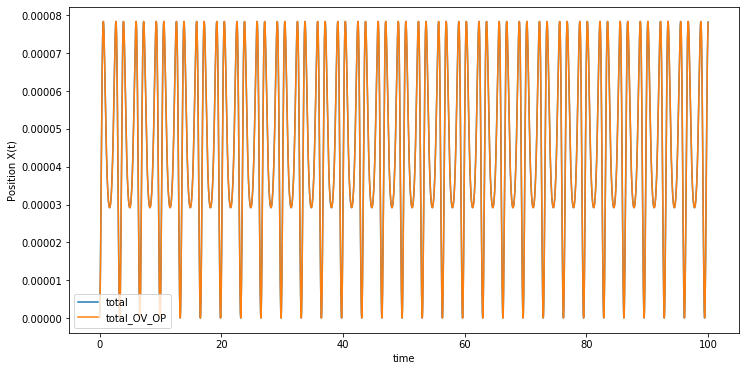

In [265]:
# Visualize the data
'''
GNUPlot
plot 'exact_dynamics.out' with lines, 'simulated_dynamics.out' using 1:2 with lp pt 6 title "position", 'simulated_dynamics.out' using 1:3 with p pt 4 title "velocity", 'simulated_dynamics.out' u 1:4 w p title "kinetic", 'simulated_dynamics.out' u 1:5 w p title "potential", "simulated_dynamics.out" u 1:6 w p title "total"
'''

import matplotlib.pyplot as plt
#%matplotlib notebook
#%matplotlib notebook
%matplotlib inline


import numpy as np

simulated_result_file = np.loadtxt("data/dynamics_mass={}_x0={}_t={}_deltaT={}.out".format(*params__))

fig=plt.figure(figsize=(12, 6))

#plt.plot(exact_dynamics_file[:,0],exact_dynamics_file[:,1],'r+', label='exact_dynamics', linewidth=1, markersize=3, linestyle='dashed')
#plt.plot(simulated_result_file[:,0],simulated_result_file[:,1], label='position')
#plt.plot(simulated_result_file[:,0],simulated_result_file[:,2], label='position_OV_OP')
#plt.plot(simulated_result_file[:,0],simulated_result_file[:,2], label='velocity')
#plt.plot(simulated_result_file[:,0],simulated_result_file[:,3], label='kinetic')
#plt.plot(simulated_result_file[:,0],simulated_result_file[:,5], label='potential')
plt.plot(simulated_result_file[:,0],abs(simulated_result_file[:,6]-simulated_result_file[0,6])/simulated_result_file[0,6], label='total')
plt.plot(simulated_result_file[:,0],abs(simulated_result_file[:,7]-simulated_result_file[0,7])/simulated_result_file[0,7], label='total_OV_OP')
plt.xlabel('time')
plt.ylabel('Position X(t)')
plt.legend()

